# Analyse de setiments sur le dataset IMDB

**Objectif** Finetuner un LLM afin qu'il puisse déterminer si un commentaire, fait par un utilisateur à propos d'un film, est positif ou négatif.<br>
Comparer sa précision avec un modèle "baseline" classique.

## Partie 1 - Analyse et Interprétation des données


### 1.1 Vérification des données
Dans un premier temps, vérifions que nos données sont correctes : en avons nous suffisement ? Sont elles bien réparties ?

In [ ]:
!pip install datasets matplotlib wordcloud
!pip install emoji

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji

from datasets import load_dataset

# load dataset
dataset = load_dataset("imdb")

# set as DataFrames
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

#### Vérification des doublons et valeurs manquantes

In [ ]:
print("Missing values (train):\n", df_train.isna().sum())
print("Missing values (test):\n", df_test.isna().sum())

print("Duplicated rows in train:", df_train.duplicated(subset="text").sum())
print("Duplicated rows in test:", df_test.duplicated(subset="text").sum())

Missing values (train):
 text     0
label    0
dtype: int64
Missing values (test):
 text     0
label    0
dtype: int64
Duplicated rows in train: 96
Duplicated rows in test: 199


Aucune valeur manquantes. On voit en revanche des valeurs doublées, regardons si ces doublons donnent le même label (par exemple, une personne pourrait dire "this actor is insane" positivement et une autre négativement).



In [ ]:
dup_texts = df_train[df_train.duplicated(subset="text", keep=False)]
dup_groups = dup_texts.groupby("text")["label"].agg(list).reset_index()
conflicts = dup_groups[dup_groups["label"].apply(lambda x: len(set(x)) > 1)]

print(f"Inconsistent duplicates (same text but different labels): {len(conflicts)}")

Inconsistent duplicates (same text but different labels): 0


On voit que les texts dupliqués ont le même label. On peut donc retirer les doublons de notre dataset.



In [ ]:
# Remove duplicates in train
before_train = len(df_train)
df_train_clean = df_train.drop_duplicates(subset="text", keep="first").reset_index(drop=True)
after_train = len(df_train_clean)

print(f"Train set: {before_train} → {after_train} (removed {before_train - after_train} duplicates)")

# Remove duplicates in test
before_test = len(df_test)
df_test_clean = df_test.drop_duplicates(subset="text", keep="first").reset_index(drop=True)
after_test = len(df_test_clean)

print(f"Test set: {before_test} → {after_test} (removed {before_test - after_test} duplicates)")

Train set: 25000 → 24904 (removed 96 duplicates)
Test set: 25000 → 24801 (removed 199 duplicates)


#### Vérification des Labels
Vérifions que nos labels sont bien répartis équitablement

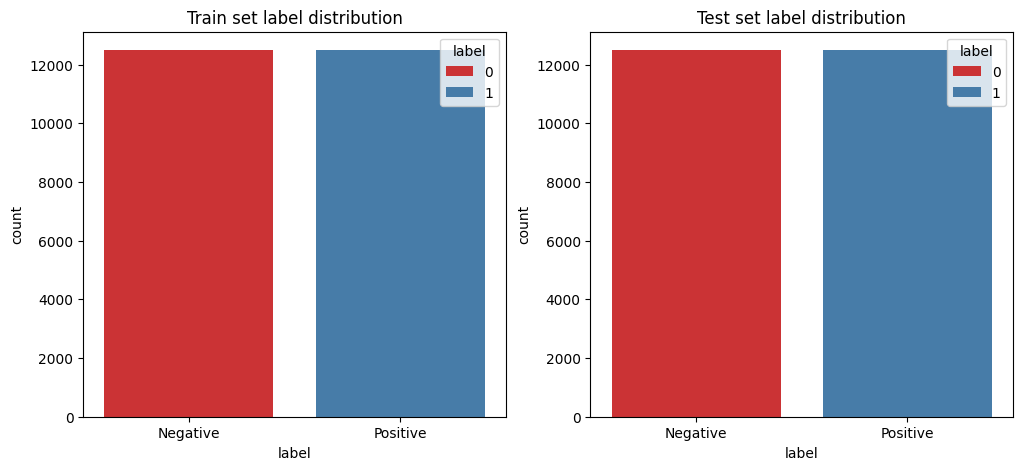

Train label distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Test label distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# Count labels in train/test
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x="label", data=df_train, ax=axes[0], hue="label", palette="Set1")
axes[0].set_title("Train set label distribution")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Negative", "Positive"])

sns.countplot(x="label", data=df_test, ax=axes[1], hue="label", palette="Set1")
axes[1].set_title("Test set label distribution")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Negative", "Positive"])

plt.show()

print("Train label distribution:\n", df_train['label'].value_counts(normalize=True))
print("Test label distribution:\n", df_test['label'].value_counts(normalize=True))


En ce qui concere les labels tout va bien, les données sont bien réparties.


#### Examples de review
Regardons à quoi ressemble nos données d'entré

In [ ]:
print("Example positive review:\n")
print(df_train[df_train['label']==1]['text'].iloc[:5][:500])

print("\nExample negative review:\n")
print(df_train[df_train['label']==0]['text'].iloc[:5][:500])


Example positive review:

12500    Zentropa has much in common with The Third Man...
12501    Zentropa is the most original movie I've seen ...
12502    Lars Von Trier is never backward in trying out...
12503    *Contains spoilers due to me having to describ...
12504    That was the first thing that sprang to mind a...
Name: text, dtype: object

Example negative review:

0    I rented I AM CURIOUS-YELLOW from my video sto...
1    "I Am Curious: Yellow" is a risible and preten...
2    If only to avoid making this type of film in t...
3    This film was probably inspired by Godard's Ma...
4    Oh, brother...after hearing about this ridicul...
Name: text, dtype: object


Les données sont bien des "raw" commentaires d'utilisateurs. On comprend donc que l'on aura probablement à faire à des fautes d'orthographe, de synthaxe, des emojis, ...
Faisons une petite analyse de nos données pour voir si l'on retrouve ce genre de choses

In [ ]:
def detect_strange_text(text):
    """
    Detects if a text contains emojis, strange characters or abnormal tokens.
    Returns a dict with flags.
    """
    result = {
        "has_emoji": bool(emoji.emoji_list(text)),
        "has_non_ascii": bool(re.search(r"[^\x00-\x7F]", text)),  # non standard ASCII
        "has_repeated_letters": bool(re.search(r"(.)\1{4,}", text)),  # e.g. 'sooooo'
    }
    return result

# Apply to dataset (train sample)
sample_check = df_train['text'].sample(10, random_state=42).apply(detect_strange_text)
print(sample_check)

# Percentage of reviews with anomalies
flags = df_train['text'].apply(lambda x: detect_strange_text(x))

flags_df = pd.DataFrame(flags.tolist())
print(flags_df.mean())  # proportion of True values per category

6868     {'has_emoji': False, 'has_non_ascii': False, '...
24016    {'has_emoji': False, 'has_non_ascii': False, '...
9668     {'has_emoji': False, 'has_non_ascii': False, '...
13640    {'has_emoji': False, 'has_non_ascii': False, '...
14018    {'has_emoji': False, 'has_non_ascii': False, '...
7488     {'has_emoji': False, 'has_non_ascii': False, '...
5804     {'has_emoji': False, 'has_non_ascii': True, 'h...
12909    {'has_emoji': False, 'has_non_ascii': False, '...
3386     {'has_emoji': False, 'has_non_ascii': False, '...
9567     {'has_emoji': False, 'has_non_ascii': False, '...
Name: text, dtype: object
has_emoji               0.00016
has_non_ascii           0.09388
has_repeated_letters    0.03892
dtype: float64


On peut voir que l'on a effectivement des caractères spéciaux et des emojis dans nos commentaires. Cela représente cela dit un faible pourcentage de nos données.

#### Longueur des commentaires

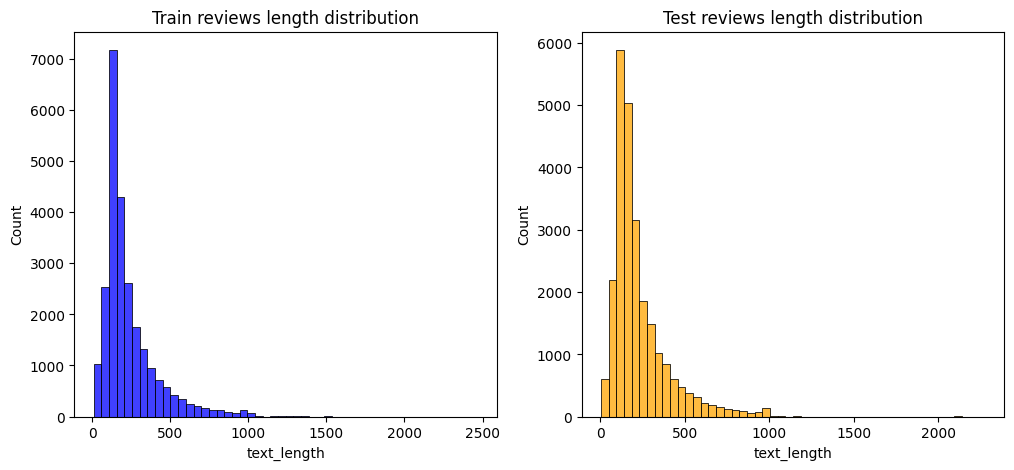

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
90%        458.000000
95%        598.000000
max       2470.000000
Name: text_length, dtype: float64


In [ ]:
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_train["text_length"], bins=50, ax=axes[0], color="blue")
axes[0].set_title("Train reviews length distribution")
sns.histplot(df_test["text_length"], bins=50, ax=axes[1], color="orange")
axes[1].set_title("Test reviews length distribution")
plt.show()

print(df_train["text_length"].describe(percentiles=[.25, .5, .75, .9, .95]))

### 1.2 Représentation des mots
Quels sont les mots les plus utilisés dans un commentaire négatif ou positif ?

#### Top 20 des mots les plus utilisés
Regardons pour chaque label quels sont les mots les plus récurrents


In [ ]:
from collections import Counter
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

# count positives / negatives
pos_words = Counter([w for text in df_train[df_train['label']==1]['text'] for w in tokenize(text)])
neg_words = Counter([w for text in df_train[df_train['label']==0]['text'] for w in tokenize(text)])

print("Top 20 mots positifs:", pos_words.most_common(20))
print("Top 20 mots négatifs:", neg_words.most_common(20))

Top 20 mots positifs: [('the', 173344), ('and', 89747), ('a', 83723), ('of', 76855), ('to', 66749), ('is', 57247), ('in', 50221), ('br', 49235), ('it', 48074), ('i', 40774), ('that', 35646), ('this', 35085), ('s', 32832), ('as', 26309), ('with', 23250), ('for', 22417), ('was', 21918), ('film', 20940), ('but', 20835), ('movie', 19078)]
Top 20 mots négatifs: [('the', 163405), ('a', 79400), ('and', 74393), ('of', 69009), ('to', 68975), ('br', 52636), ('is', 50085), ('it', 48393), ('i', 46916), ('in', 43755), ('this', 40922), ('that', 37640), ('s', 30770), ('was', 26291), ('movie', 24969), ('for', 21928), ('but', 21788), ('with', 20880), ('as', 20626), ('t', 20584)]


#### Filtrer les mots neutres
Comme nous pouvons le constater, les mots les plus utilisés sont des mots neutres : "the", "and", "a", ...
Afin d'avoir une meilleur représentation, enlevons les mots qui sont preque autant présents dans les deux catégories

In [ ]:
def remove_weakly_discriminant(pos_counter, neg_counter, threshold=0.5):
    """
    Remove words that are too common in both classes.
    A word is removed if its count in one class is >= threshold * count in the other class.
    """
    pos_filtered = Counter()
    neg_filtered = Counter()

    # Process positive words
    for w, c in pos_counter.items():
        other_count = neg_counter.get(w, 0)
        if other_count < threshold * c:  # keep only if relatively discriminant
            pos_filtered[w] = c

    # Process negative words
    for w, c in neg_counter.items():
        other_count = pos_counter.get(w, 0)
        if other_count < threshold * c:
            neg_filtered[w] = c

    return pos_filtered, neg_filtered


# Example usage
pos_clean, neg_clean = remove_weakly_discriminant(pos_words, neg_words, threshold=0.5)

print("Top discriminant positive words:", pos_clean.most_common(20))
print("Top discriminant negative words:", neg_clean.most_common(20))

Top discriminant positive words: [('great', 6419), ('best', 4320), ('excellent', 1683), ('beautiful', 1582), ('wonderful', 1372), ('perfect', 1242), ('performances', 1238), ('loved', 1087), ('amazing', 1059), ('favorite', 962), ('heart', 959), ('today', 936), ('brilliant', 927), ('enjoyed', 879), ('highly', 871), ('strong', 768), ('simple', 695), ('episodes', 657), ('relationship', 656), ('fantastic', 654)]
Top discriminant negative words: [('bad', 7401), ('nothing', 2990), ('worst', 2479), ('minutes', 2123), ('script', 2075), ('2', 1950), ('money', 1640), ('awful', 1557), ('1', 1521), ('poor', 1481), ('instead', 1479), ('boring', 1479), ('stupid', 1428), ('terrible', 1391), ('waste', 1359), ('worse', 1249), ('supposed', 1186), ('oh', 1086), ('horrible', 1046), ('couldn', 1042)]


Les mots ressortits semblent parfaitement cohérents. Affichons les afin d'en avoir une meilleur représentation.

#### Nuage de mots

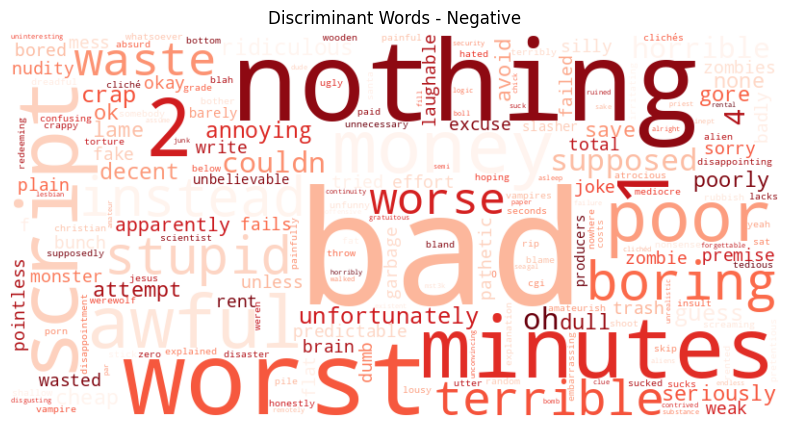

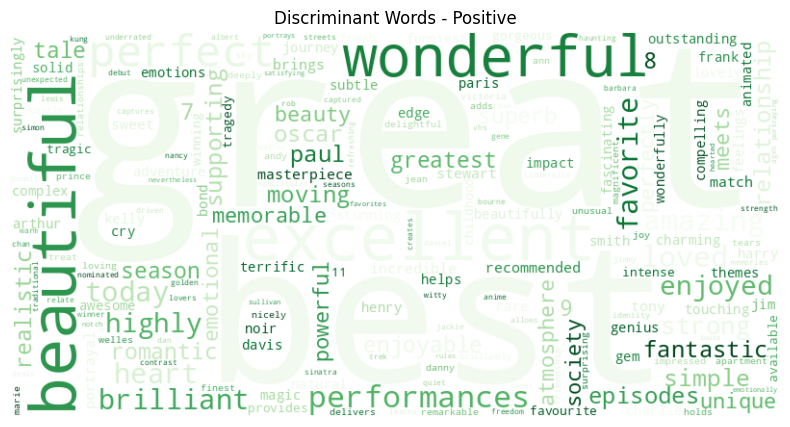

In [ ]:
from wordcloud import WordCloud

# Reconstruct text from filtered discriminant words
pos_text_filtered = " ".join([w for w, c in pos_clean.items() for _ in range(c)])
neg_text_filtered = " ".join([w for w, c in neg_clean.items() for _ in range(c)])

# -- WordCloud negative (discriminant)
wordcloud_neg = WordCloud(width=800, height=400, background_color="white", colormap='Reds').generate_from_frequencies(neg_clean)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Discriminant Words - Negative")
plt.show()

# -- WordCloud positive (discriminant)
wordcloud_pos = WordCloud(width=800, height=400, background_color="white", colormap='Greens').generate_from_frequencies(pos_clean)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Discriminant Words - Positive")
plt.show()

#### Plot bar

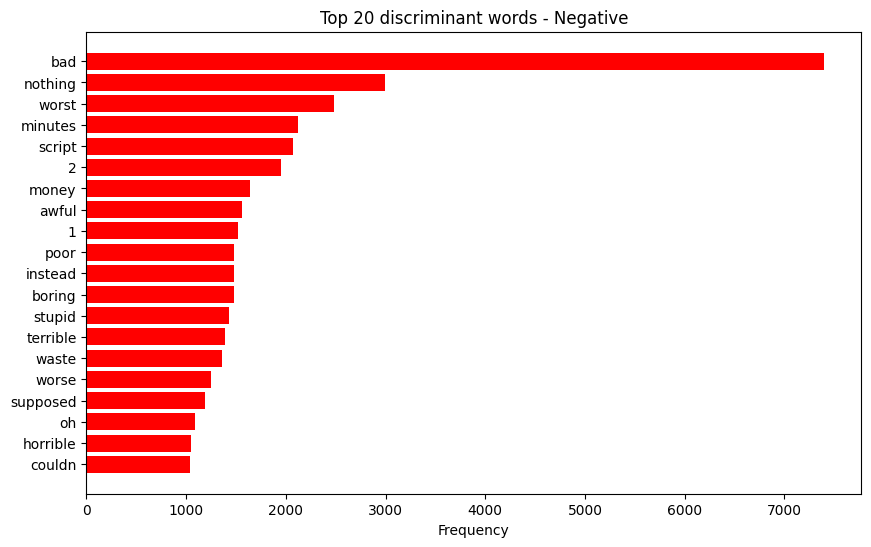

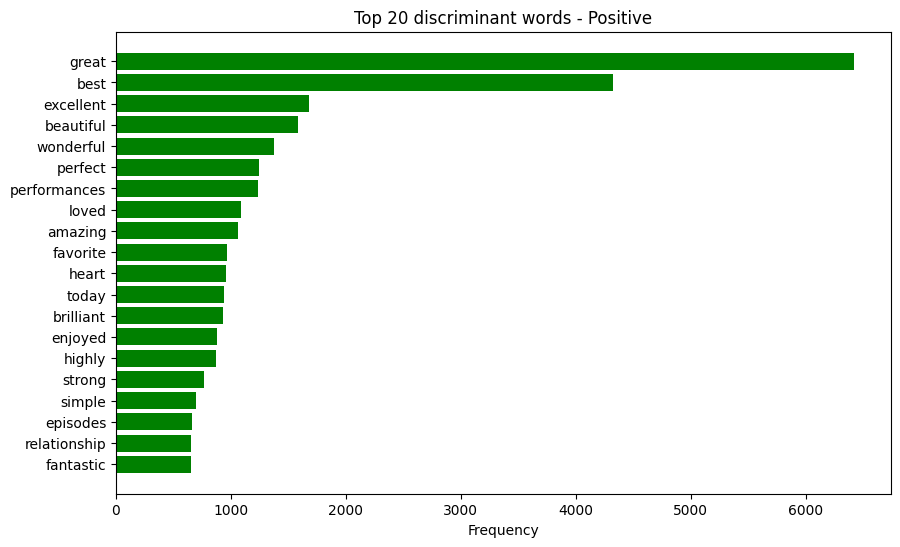

In [ ]:
def plot_top_words(counter, label, n=20, color="green"):
    # Get the top-N most frequent words
    top_words = counter.most_common(n)
    words, counts = zip(*top_words)

    plt.figure(figsize=(10,6))
    plt.barh(words[::-1], counts[::-1], color=color)
    plt.xlabel("Frequency")
    plt.title(f"Top {n} discriminant words - {label}")
    plt.show()

# Plot Top 20 for negative words
plot_top_words(neg_clean, "Negative", n=20, color="red")

# Plot Top 20 for positive words
plot_top_words(pos_clean, "Positive", n=20, color="green")

### Conclusions
Le jeu de donné est bien fournit (50 000 data) et propre (données variées, bien représentatives, bien réparties). Il ne semble pas nécessaire d'aller chercher d'autres jeux de données pour le compléter.
Les IA devraient facilement réeussir à effectuer une analyse de sentiments.

## Partie 2 Baseline Model (TF-IDF + LogReg)
En modèle de base, prennons une pipeline simple, rapide et efficace :

*   Vectorisation TF-IDF des reviews (transformer les textes en vecteurs pondérés).

*   Logistic Regression comme classificateur.


In [ ]:
# Install scikit-learn if needed
!pip install scikit-learn -q

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Use the clean datasets (no duplicates)
X_train = df_train_clean["text"].values
y_train = df_train_clean["label"].values

X_test = df_test_clean["text"].values
y_test = df_test_clean["label"].values

# Define pipeline: TF-IDF + Logistic Regression
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=200, solver="saga"))
])

# Train
baseline_model.fit(X_train, y_train)

# Predict
y_pred = baseline_model.predict(X_test)

# Evaluate
print("Baseline TF-IDF + Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

Baseline TF-IDF + Logistic Regression
Accuracy: 0.8945203822426515

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.89      0.89     12361
    Positive       0.89      0.90      0.90     12440

    accuracy                           0.89     24801
   macro avg       0.89      0.89      0.89     24801
weighted avg       0.89      0.89      0.89     24801



Explications des paramètres :

**TfidfVectorizer**
  - max_features=50000 : limite le vocabulaire (évite explosion mémoire).

  - ngram_range=(1,2) : prend en compte mots seuls + bigrammes (ex. "very good", "not bad").

**LogisticRegression**

  - solver = "saga" gère bien les grands datasets.

## Partie 3 Modèles finetuné

### Modèles candidats pour le fine-tuning
1. **BERT-base**

  - Type : Transformer bidirectionnel.
  - Taille : 110M paramètres.
  - Avantages : Standard très robuste pour classification de texte.
  - Inconvénients : Modèle un peu ancien, parfois dépassé par des modèles plus récents.

2. **DistilBERT** *(selectionné)*

  - Type : Version compressée de BERT (40% plus petit, 60% plus rapide).
  - Taille : 66M paramètres.
  - Avantages : Plus rapide et moins coûteux en ressources GPU - parfait pour Google Colab.
  - Inconvénients : Légère baisse de performance (~1-2% de moins que BERT-base).

3. **RoBERTa-base**

  - Type : BERT retravaillé avec plus de données et un entraînement plus long.
  - Taille : 125M paramètres.
  - Avantages : Plus performant que BERT sur la plupart des benchmarks NLP.
  - Inconvénients : Plus lourd, plus lent que DistilBERT.


J'ai donc choisit DistilBERT, je trouve que c’est un compromis excellent entre performance et efficacité (surtout sur GPU Colab qui a une mémoire limitée).
Fine-tuning rapide, et il est supporté directement par Hugging Face.

### Installations

In [ ]:
!pip install transformers datasets evaluate accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


### 3.1 Prétraitement (tokenisation)

In [ ]:
from transformers import DistilBertTokenizerFast

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize function
def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_fn, batched=True)

# Keep only necessary columns
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset.set_format("torch")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

### 3.2 Préparation du modèle

In [ ]:
from transformers import DistilBertForSequenceClassification

# Load DistilBERT with classification head
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.3 Training setup

In [ ]:
from transformers import TrainingArguments, Trainer
import evaluate

# Metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

### 3.4 Entrainement

In [ ]:
# define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

# train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.236400,0.229528,0.910520


TrainOutput(global_step=1563, training_loss=0.28296643301072366, metrics={'train_runtime': 694.268, 'train_samples_per_second': 36.009, 'train_steps_per_second': 2.251, 'total_flos': 1655842483200000.0, 'train_loss': 0.28296643301072366, 'epoch': 1.0})

## Partie 4 : Comparaison des modèles

### 4.1 Évaluation Baseline

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_baseline = baseline_model.predict(X_test)
acc_baseline = accuracy_score(y_test, y_pred_baseline)

print("Baseline TF-IDF + LogReg Accuracy:", acc_baseline)
print(classification_report(y_test, y_pred_baseline, target_names=["Negative", "Positive"]))

Baseline TF-IDF + LogReg Accuracy: 0.8945203822426515
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89     12361
    Positive       0.89      0.90      0.90     12440

    accuracy                           0.89     24801
   macro avg       0.89      0.89      0.89     24801
weighted avg       0.89      0.89      0.89     24801



### 4.2 Évaluation DistilBERT

In [ ]:
import numpy as np

results_bert = trainer.evaluate()
acc_bert = results_bert["eval_accuracy"]

print("DistilBERT Accuracy:", acc_bert)

preds = trainer.predict(tokenized_dataset["test"])
y_pred_bert = np.argmax(preds.predictions, axis=1)
y_true_bert = preds.label_ids

print(classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"]))

DistilBERT Accuracy: 0.91052
              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91     12500
    Positive       0.92      0.90      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



### 4.3 Matrice de confusion

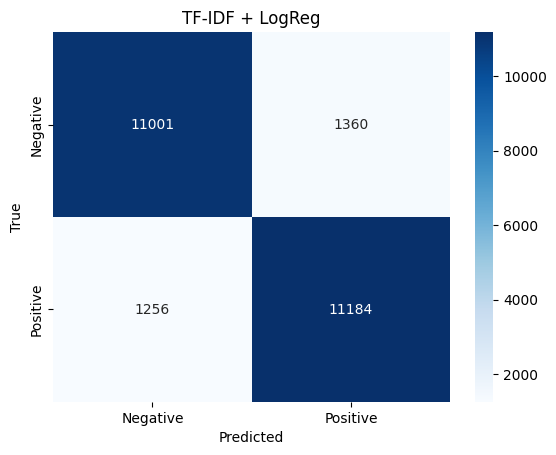

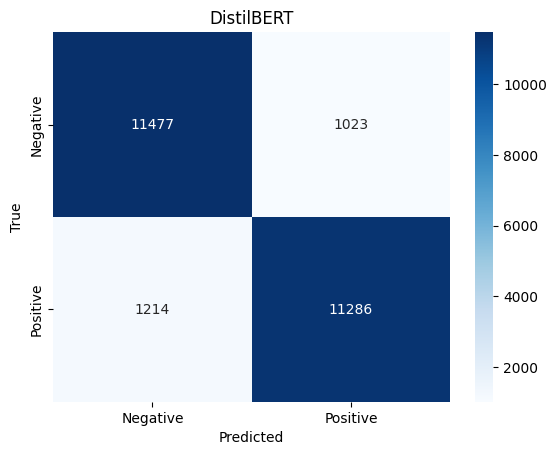

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative","Positive"],
                yticklabels=["Negative","Positive"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Baseline confusion matrix
plot_confusion(y_test, y_pred_baseline, "TF-IDF + LogReg")

# DistilBERT confusion matrix
plot_confusion(y_true_bert, y_pred_bert, "DistilBERT")

In [ ]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["TF-IDF + LogReg", "DistilBERT"],
    "Accuracy": [acc_baseline, acc_bert]
})

print(comparison)

             Model  Accuracy
0  TF-IDF + LogReg   0.89452
1       DistilBERT   0.91052
